This notebook was run in google CoLab and should be run there such that none of the packages should have to be installed on your local machine.

In [1]:
%%capture 
!pip install --pre deepchem
!pip install rdkit-pypi
!pip install PyTDC
!pip install lime

In [2]:
import deepchem as dc
import scipy
import numpy as np 
import pandas as pd
from tdc.single_pred import Tox

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, FragmentOnBonds
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ParameterGrid

from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)

# Load in Data

In [3]:
data = Tox(name = 'Skin Reaction')
df = data.get_data()

Downloading...
100%|██████████| 26.7k/26.7k [00:00<00:00, 5.38MiB/s]
Loading...
Done!


In [4]:
df

,Drug_ID,Drug,Y
0,(16-b)-21-(Acetyloxy)-17-hydroxy-16-methylpreg...,CC(=O)OCC(=O)C1(O)C(C)CC2C3CCC4=CC(=O)C=CC4(C)...,0
1,(2-Bromo-5-propoxyphenyl)-(2-hydroxy-4-methoxy...,CCCOc1ccc(Br)c(C(=O)c2ccc(OC)cc2O)c1,0
2,(2E)-2-Methyl-2-butenal,CC=C(C)C=O,0
3,(2-oxo-1-phenylpyrrolidin-3-yl)-Triphenylphosp...,O=C1C([PH](c2ccccc2)(c2ccccc2)c2ccccc2)CCN1c1c...,0
4,(4Z)-2-Methyl-6-methylene-4-octene,C=C(C=CCC(C)C)CC,0
...,...,...,...
399,Maleic anhydride,O=C1C=CC(=O)O1,1
400,"N,N-dimethyl-4-nitrosoaniline",CN(C)c1ccc(N=O)cc1,1
401,Phthalic anhydride,O=C1OC(=O)c2ccccc21,1
402,Propyl gallate,CCCOC(=O)c1cc(O)c(O)c(O)c1,1


## Data Preprocessing

Here, we impute any potential missingness though none is present. We then featurize our drug molecules using the circular fingerprint featurizer from DeepChem.

In [5]:
# Address Potential Missingness
df.dropna(subset = ['Drug'], inplace = True)
df.drop_duplicates(subset=['Drug_ID'], keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True)

# Build Morgan Fingerprints for Skin Reaction DS
PandasTools.AddMoleculeColumnToFrame(df,'Drug','molecule')
featurizer = dc.feat.CircularFingerprint(size=1024, radius=4)
morgFP = featurizer.featurize(df['molecule'])

Dataset consistsfor 404 unique molecules, each with a unique Morgan Fingerprint.

In [6]:
morgFP.shape

(404, 1024)

In [7]:
procced_df = pd.DataFrame(morgFP)

We split up our data into a training and test set for cross validation with a 70/30 respective split.

In [8]:
X_train, x_test, Y_train, y_test = train_test_split(procced_df,df['Y'],test_size=.3,random_state=0)

In [9]:
Y_train.shape

(282,)

Defeaturizer which we use to understand which structure belongs to which morgan fingerprint feature.

In [10]:
def fp_mol(mol, fp_length=1024):
    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of SMILES strings that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=1024)
    retval = feat._featurize(mol)
    for k, v in retval.items():
        index = k % fp_length
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    d = {key:val for key, val in d.items() if val != {''}}
    return d

### set up for multi-task classifier

Initializing dataset objects for our ResNet model to use.

In [11]:
ds_train = dc.data.NumpyDataset(X=X_train,y=Y_train)
ds_test = dc.data.NumpyDataset(X=x_test,y=y_test)

## Data Exploration

Performing PCA.

In [12]:
pca = PCA(n_components=50).fit(morgFP)

We see that the first 2 principal components explain about 9% of the variance of the dataset.

In [13]:
pca.explained_variance_ratio_[0:2]

array([0.05680711, 0.03304522])

In [14]:
morgFP_DR = pca.fit_transform(morgFP)

#### K-Means clustering to check for better non-linear separations.

In [15]:
def ElbowVis(df):
  distortions = []
  for i in range(2,18):
    temp_model = KMeans(n_clusters=i,random_state=0)
    temp_model.fit(df)
    distortions.append(temp_model.inertia_)
  return distortions

Distortion at k = 5:  11513.378825166052


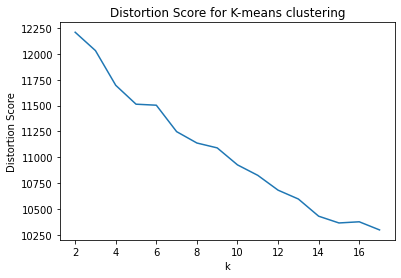

In [16]:
plt.plot(range(2,18),ElbowVis(morgFP))
plt.title('Distortion Score for K-means clustering')
plt.xlabel('k')
plt.ylabel('Distortion Score')
print('Distortion at k = 5: ', ElbowVis(morgFP)[3])

We choose our number of clusters to be 14. While there seems to be inflection at 4 or 5, the number of clusters would have too much mixing between both classes within each cluster.

In [35]:
kmeans = KMeans(n_clusters=14,random_state=0).fit(morgFP)
df['cluster'] = kmeans.labels_

In [36]:
temp1 = df['cluster'].value_counts()
kmean_df = pd.DataFrame({'cluster_index':list(range(0,14))})
kmean_df = kmean_df.merge(temp1,left_on='cluster_index',right_index=True)
kmean_df

,cluster_index,cluster
0,0,17
1,1,2
2,2,4
3,3,49
4,4,7
5,5,35
6,6,52
7,7,23
8,8,3
9,9,123


#### PCA Figures

Text(0.5, 1.0, 'Principle Component Analysis; Skin Reaction Label')

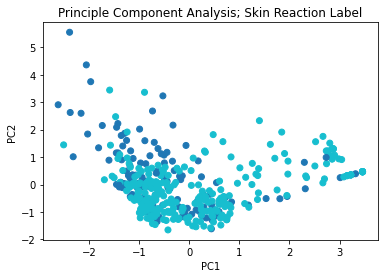

In [37]:
pc1 = morgFP_DR[0::,0:1]
pc2 = morgFP_DR[0::,1:2]
plt.scatter(pc1,pc2,c=df['Y'],cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principle Component Analysis; Skin Reaction Label')

Poor separation is seen between classes even in this space of principal components.

Text(0.5, 1.0, 'Principle Component Analysis; cluster index')

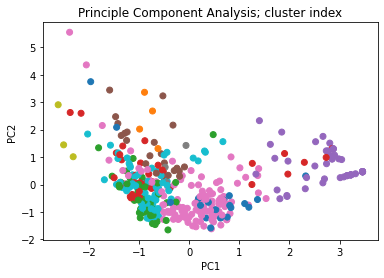

In [38]:
pc1 = morgFP_DR[0::,0:1]
pc2 = morgFP_DR[0::,1:2]
plt.scatter(pc1,pc2,c=df['cluster'],cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principle Component Analysis; cluster index')

Even clustering does not seem to assist with the dense aggregation of points close to PC1 = 0, PC2 = -1.

#### T-SNE Figures

In [39]:
morg_TSNE = TSNE(n_components=2,random_state=0).fit_transform(morgFP_DR)

Text(0.5, 1.0, 'T-SNE; Skin Reaction Label')

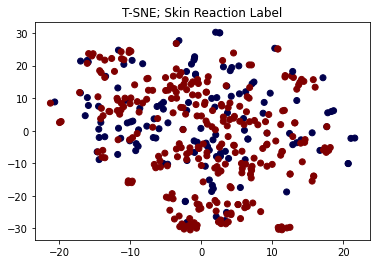

In [40]:
plt.scatter(morg_TSNE[:,0],morg_TSNE[:,1],c=df['Y'],cmap='seismic')
plt.title('T-SNE; Skin Reaction Label')

Separation between classes is poor even in this stochastic neighbor embedded space. However, with a more complex non-linear model, it would apear to be feasible to at least separate the classes.

Text(0.5, 1.0, 'T-SNE; Cluster Index')

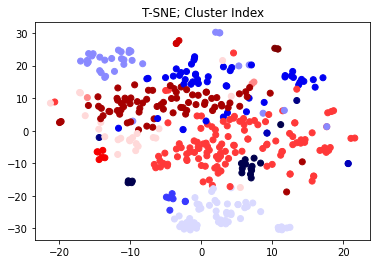

In [41]:
plt.scatter(morg_TSNE[:,0],morg_TSNE[:,1],c=df['cluster'],cmap='seismic')
plt.title('T-SNE; Cluster Index')

We use our k-means clustering again to shade our data points and we see that separation is subsntial for at least some of the clusters so nonlinear methods will be our best choice for classification.

#### Simple Physical Descriptors Derived from Molecular Structure

In [25]:
df2 = data.get_data()
df2['MolWt'] = df['molecule'].apply(Chem.Descriptors.MolWt)
df2['MolLogP'] = df['molecule'].apply(Chem.Descriptors.MolLogP)
df2['NumHAcceptors'] = df['molecule'].apply(Chem.Descriptors.NumHAcceptors)
df2['NumHDonors'] = df['molecule'].apply(Chem.Descriptors.NumHDonors)
df2['HeavyAtomCount'] = df['molecule'].apply(Chem.Descriptors.HeavyAtomCount)
df2['HeavyAtomMolWt'] = df['molecule'].apply(Chem.Descriptors.HeavyAtomMolWt)
df2['Wt%'] = df2['HeavyAtomMolWt']/df2['MolWt']
df2['MaxPartialCharge'] = df['molecule'].apply(Chem.Descriptors.MaxPartialCharge)
df2['MinPartialCharge'] = df['molecule'].apply(Chem.Descriptors.MinPartialCharge)
df2
df2.to_csv('drug_data.csv')

In [26]:
#calculate correlation coefficients
def calc_r(x,y):
  r = np.corrcoef(x,y)[0,1]
  return round(r,3)

0.509
0.632
0.268
0.971
0.998
0.088


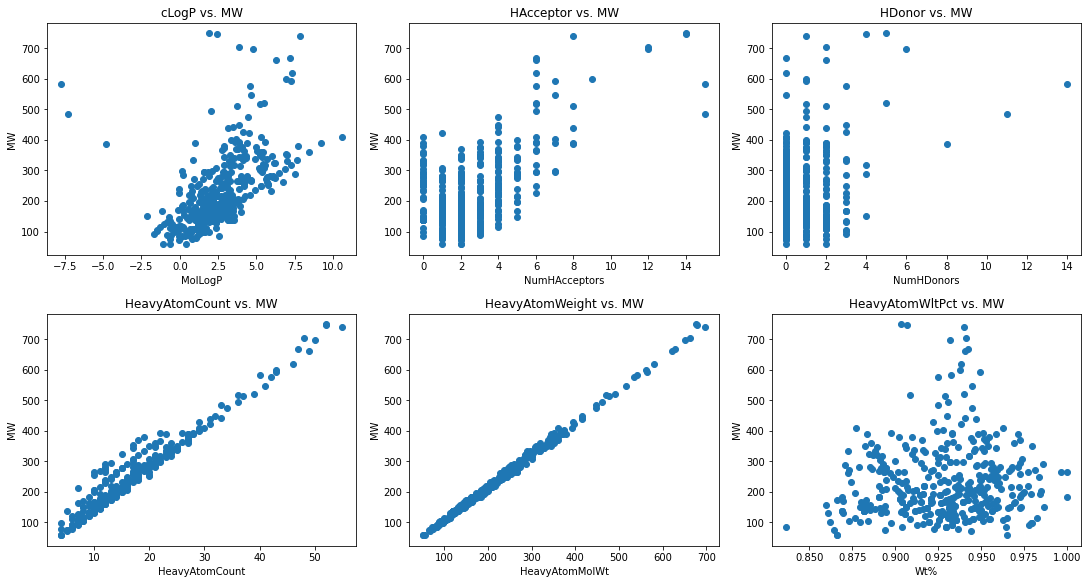

In [27]:
# Please write your code below
fig,axs = plt.subplots(2,3,figsize=(15,8),constrained_layout=True)

axs[0,0].scatter(df2['MolLogP'],df2['MolWt'])
axs[0,0].set_title('cLogP vs. MW')
axs[0,0].set_ylabel('MW')
axs[0,0].set_xlabel('MolLogP')
print(calc_r(df2['MolLogP'],df2['MolWt']))

axs[0,1].scatter(df2['NumHAcceptors'],df2['MolWt'])
axs[0,1].set_title('HAcceptor vs. MW')
axs[0,1].set_ylabel('MW')
axs[0,1].set_xlabel('NumHAcceptors')
print(calc_r(df2['NumHAcceptors'],df2['MolWt']))

axs[0,2].scatter(df2['NumHDonors'],df2['MolWt'])
axs[0,2].set_title('HDonor vs. MW')
axs[0,2].set_ylabel('MW')
axs[0,2].set_xlabel('NumHDonors')
print(calc_r(df2['NumHDonors'],df2['MolWt']))

axs[1,0].scatter(df2['HeavyAtomCount'],df2['MolWt'])
axs[1,0].set_title('HeavyAtomCount vs. MW')
axs[1,0].set_ylabel('MW')
axs[1,0].set_xlabel('HeavyAtomCount')
print(calc_r(df2['HeavyAtomCount'],df2['MolWt']))

axs[1,1].scatter(df2['HeavyAtomMolWt'],df2['MolWt'])
axs[1,1].set_title('HeavyAtomWeight vs. MW')
axs[1,1].set_ylabel('MW')
axs[1,1].set_xlabel('HeavyAtomMolWt')
print(calc_r(df2['HeavyAtomMolWt'],df2['MolWt']))

axs[1,2].scatter(df2['Wt%'],df2['MolWt'])
axs[1,2].set_title('HeavyAtomWltPct vs. MW')
axs[1,2].set_ylabel('MW')
axs[1,2].set_xlabel('Wt%')
print(calc_r(df2['Wt%'],df2['MolWt']))


Here, we have plots for features against molecular weight, and we realized 2 things. It would be difficult to extract the chemical substructure from these descriptors and some of these features correlate too much with molecular weight that some of these features such as Heavy Atom Weight and Heavy Atom Count would function as duplicate columns for molecular weight.

# Models

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [73]:
LR = LogisticRegression().fit(X_train,Y_train)
LR_acc = metrics.accuracy_score(y_test,LR.predict(x_test))
LR_prec = metrics.precision_score(y_test,LR.predict(x_test))
print('Logistic Classifier Accuracy: \n',LR_acc)
print('Precision: \n', LR_prec)
print('Recall: \n',metrics.recall_score(y_test,LR.predict(x_test)))

Logistic Classifier Accuracy: 
 0.7295081967213115
Precision: 
 0.7422680412371134
Recall: 
 0.9


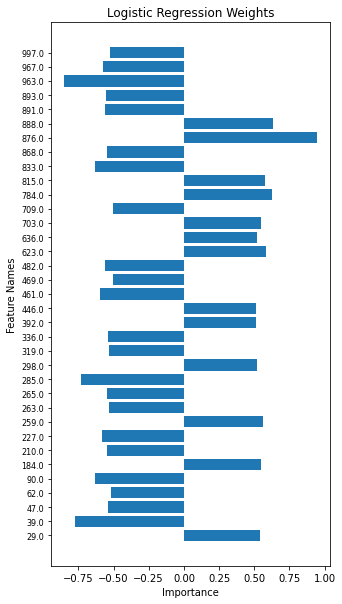

In [95]:
weights = LR.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(weights[0]) if np.abs(v) > 0.5]
# print(non_zero_index_list)

# remove all zero value entries
fragments = np.linspace(0,1023,1024)
fragments = [str(i) for i in fragments]
non_zero_feature_names = [fragments[i] for i in non_zero_index_list]
non_zero_importance = [weights[0][i] for i in non_zero_index_list]

fig,ax = plt.subplots(figsize=(5,10))
plt.barh(non_zero_feature_names, non_zero_importance)
ax.set_yticklabels(non_zero_feature_names, fontsize=8)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Weights')
plt.show()

In [45]:
weights[0].shape

(1024,)

## Decision Tree

In [47]:
param_grid = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':[5,10,15,20,30,40,50]}
grid =list(ParameterGrid(param_grid))

accuracies = []
for params in grid:
  # Create Decision Tree classifier object
  clf = DecisionTreeClassifier(criterion=params['criterion'],splitter=params['splitter'],max_depth=params['max_depth'],random_state=0)

  # Train Decision Tree classifier
  clf = clf.fit(X_train,Y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(x_test)
  accuracies.append(metrics.accuracy_score(y_test, y_pred))
  # number of correct predictions how often is the classifier correct?
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred), 'params: ',params)
grid[accuracies.index(max(accuracies))]

{'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}

In [48]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=10, random_state=0)

# Train Decision Tree classifier
clf = clf.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

# number of correct predictions how often is the classifier correct?
print("Accuracy:  \n",metrics.accuracy_score(y_test, y_pred))
print('Precision: \n',metrics.precision_score(y_test,clf.predict(x_test)))
print('Recall: \n',metrics.recall_score(y_test,clf.predict(x_test)))

Accuracy:  
 0.7213114754098361
Precision: 
 0.7395833333333334
Recall: 
 0.8875


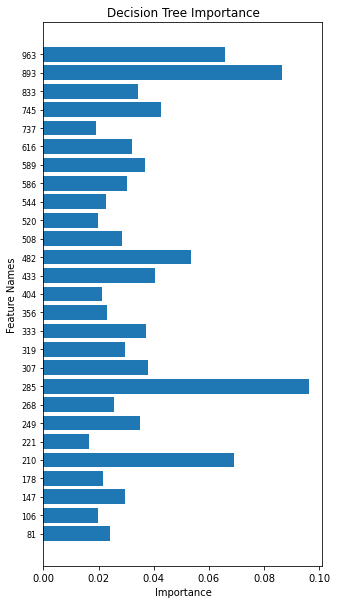

In [96]:
# get importance
importance = clf.feature_importances_.copy()

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(importance) if v > 0.01]
# print(non_zero_index_list)

# remove all zero value entries
fragments = np.linspace(0,1023,1024)
fragments = [str(int(i)) for i in fragments]
non_zero_feature_names = [fragments[i] for i in non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]

fig,ax = plt.subplots(figsize=(5,10))
plt.barh(non_zero_feature_names, non_zero_importance)
ax.set_yticklabels(non_zero_feature_names, fontsize=8)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Decision Tree Importance')
plt.show()

## Random Forest

In [50]:
#Create a Random Forest Classifier
rf = RandomForestClassifier(criterion='entropy', max_depth=20, 
                                  n_estimators=100, random_state=0)

#Train the model using the training sets
rf.fit(X_train,Y_train)
y_pred = rf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:\n",metrics.accuracy_score(y_test, y_pred))
print('Precision: \n',metrics.precision_score(y_test,rf.predict(x_test)))
print('Recall: \n',metrics.recall_score(y_test,rf.predict(x_test)))

Accuracy:
 0.7622950819672131
Precision: 
 0.7475728155339806
Recall: 
 0.9625


In [51]:
# Please write your code below:
pg = {'criterion':['gini','entropy'],'max_depth':[5,10,15,20,25,30,35],'n_estimators':[50,100,150,200,250,300]}
forest_grid = ParameterGrid(pg)

accuracies_rf = []
for param in forest_grid:
  rf = RandomForestClassifier(criterion=param['criterion'],n_estimators=param['n_estimators'],max_depth=param['max_depth'],random_state=0)
  rf.fit(X_train,Y_train)
  y_pred = rf.predict(x_test)
  accuracies_rf.append(metrics.accuracy_score(y_test, y_pred))
forest_grid[accuracies_rf.index(max(accuracies_rf))]

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}

In [52]:
max(accuracies_rf)

0.7622950819672131

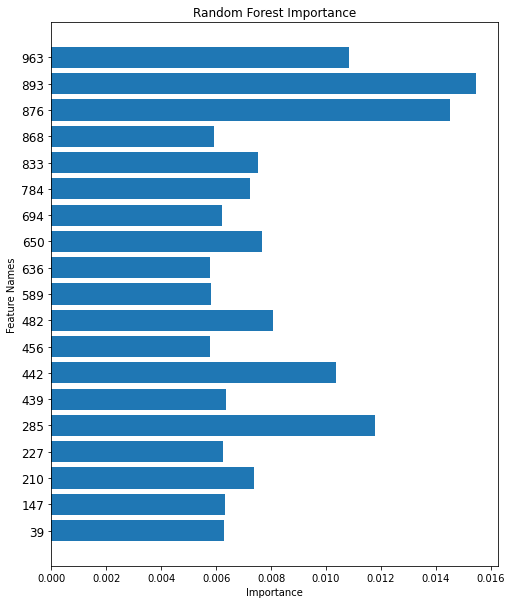

In [97]:
# Please write your code below:
rf = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=20,random_state=0)
rf.fit(X_train,Y_train)

importance_rf = rf.feature_importances_.copy()

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(importance_rf) if v > 0.005]
# print(non_zero_index_list)

# remove all zero value entries
non_zero_feature_names = [fragments[i] for i in non_zero_index_list]
non_zero_importance = [importance_rf[i] for i in non_zero_index_list]

fig,ax = plt.subplots(figsize=(8,10))
plt.barh(non_zero_feature_names, non_zero_importance)
ax.set_yticklabels(non_zero_feature_names, fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Random Forest Importance')
plt.show()

## Resnet1001

In [54]:
multitask = dc.models.MultitaskClassifier(n_tasks=1,n_features=1024)
multitask.fit(ds_test,nb_epoch=50)

0.07255239963531494

In [57]:
throwaway1,throwaway2,transformers = dc.molnet.load_tox21('ecfp')

In [58]:
print('Training accuracy: ',multitask.evaluate(ds_train,dc.metrics.accuracy_score,transformers))
print('Testing accuracy: ',multitask.evaluate(ds_test,dc.metrics.accuracy_score,transformers))

Training accuracy:  {'metric-1': 0.6560283687943262}
Testing accuracy:  {'metric-1': 1.0}


# Discussion

Find examples that are positive, and predicted positive by the decision tree and randfom forest.

In [ ]:
test_preds_rf = rf.predict(x_test)
test_preds = clf.predict(x_test)
positive_hits = []
for ind,i in enumerate(y_test):
  if((test_preds_rf[ind]>=.8) & (i==1) & (test_preds[ind]>=.8)):
    print(ind)
    positive_hits.append(ind)

In [ ]:
positive_hits[:20]

[0, 3, 4, 5, 7, 8, 11, 13, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29]

In [ ]:
y_test.index[positive_hits[:20]]

Int64Index([400, 230, 134, 297, 261, 303, 322, 326, 135, 179, 317, 259, 271,
            142, 141, 159, 369, 190, 293, 176],
           dtype='int64')

In [80]:
frags_dict = dict(zip(non_zero_feature_names, non_zero_importance))
def find_frags(index):
  my_frags = fp_mol(Chem.MolFromSmiles(df['Drug'].iloc[index]))
  for key in my_frags:
    if (str(int(key)) in frags_dict):
      if frags_dict[str(int(key))] > 0.0081:
        print('Drug index',index)
        print(str(int(key)), my_frags[key], frags_dict[str(int(key))])

In [81]:
for hit in positive_hits:
  find_frags(y_test.index[hit])

Drug index 293
893 {'C=O'} 0.01547503309058046
Drug index 176
893 {'C=C(C)CCC'} 0.01547503309058046
Drug index 362
893 {'C=O'} 0.01547503309058046
Drug index 175
893 {'C=C(C)CCC'} 0.01547503309058046
Drug index 158
893 {'CCC(CBr)C(=O)O'} 0.01547503309058046
Drug index 296
893 {'C=O'} 0.01547503309058046
Drug index 199
893 {'C=O'} 0.01547503309058046
Drug index 219
893 {'C=O'} 0.01547503309058046
Drug index 155
893 {'C=O'} 0.01547503309058046
Drug index 264
893 {'C=O'} 0.01547503309058046
Drug index 363
893 {'C=O'} 0.01547503309058046
Drug index 150
893 {'C=O'} 0.01547503309058046
Drug index 269
893 {'C=O'} 0.01547503309058046
Drug index 344
893 {'C=O'} 0.01547503309058046
Drug index 232
893 {'C=O'} 0.01547503309058046


##Visualizing Fragments

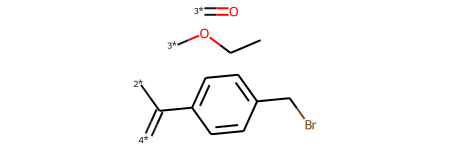

In [108]:
FragmentOnBonds(df['molecule'].iloc[293],[2,3])

In [109]:
df['Drug_ID'].iloc[293]

'4-(Bromomethyl)- benzoic acid ethyl ester'

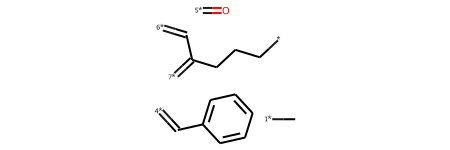

In [110]:
FragmentOnBonds(df['molecule'].iloc[176],[0,5,6])

In [111]:
df['Drug_ID'].iloc[176]

'a-Butyl cinnamic aldehyde'

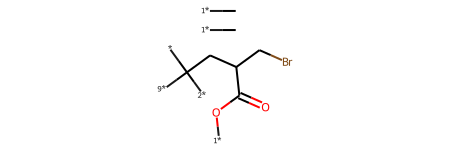

In [112]:
FragmentOnBonds(df['molecule'].iloc[158],[0,1,9])

In [113]:
df['Drug_ID'].iloc[158]

"3-Bromomethyl-5, 5'-dimethyl- dihydro-2(3H)-furanone"